# **Download and unzip dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"immanuelmayerd","key":"c0af11c2081e01520dcaa4c65a5076b8"}'}

Run this cell to install kaggle dependency, copy the file into ~/.kaggle/kaggle.json, and change file permissions to 600.

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download all the dataset using this command below.

In [ ]:
!kaggle datasets download -d immanuelmayerd/14-indonesian-wayang-types

14-indonesian-wayang-types.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip the .zip file so we can see the DATASET folders. There are few version of the dataset since we experiment with different amount of Batik motives.

In [ ]:
!unzip -qq /content/14-indonesian-wayang-types

replace DATASET/TEST/Abimanyu/80.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# **Import All Dependencies**

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import os

# **Path Control**

In [ ]:
cwd = os.getcwd()
IMAGE_SHAPE = (160, 160)
TRAINING_DATA_DIR = os.path.join(cwd,"DATASET","TRAIN")
VALID_DATA_DIR = os.path.join(cwd,"DATASET","TEST")

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.


# **Image Augmentation**

In [ ]:
train_path = '/content/DATASET/TRAIN'
test_path = '/content/DATASET/TEST'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

types_dict = train_generator.class_indices
print(types_dict)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.
{'Abimanyu': 0, 'Antasena': 1, 'Arjuna': 2, 'Bagong': 3, 'Bima': 4, 'Cepot': 5, 'Gareng': 6, 'Gatot Kaca': 7, 'Hanoman': 8, 'Kresna': 9, 'Nakula': 10, 'Petruk': 11, 'Semar': 12, 'Yudhistira': 13}


# **Using MobileNetV2 for Transfer Learning**

In [ ]:
#base model MobileNetV2
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3),
    pooling='max'
)

base_model.trainable = True

# **Scheduler**

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 50:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EPOCHS = 100
LEARNING_RATE = 1e-4
TRAIN_STEP = 700//20
VAL_STEP = 200//20

Loop Starts here :

# **Build the Model**

In [ ]:
clear_session()

model = Sequential([
    base_model,
    Dense(512, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.2),
    Dense(14, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 2,921,038
Trainable params: 2,886,926
Non-trainable params: 34,112
_________________________________________________________________


# **Train the Model and save to model_best.h5**

In [ ]:
chckp = tf.keras.callbacks.ModelCheckpoint("./model_best.h5", monitor='val_accuracy', mode='max', save_best_only=True )

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback, chckp]
)

Epoch 1/100
35/35 [==============================] - 12s 238ms/step - loss: 3.0207 - accuracy: 0.3671 - val_loss: 1.7327 - val_accuracy: 0.6200 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - 7s 202ms/step - loss: 1.4407 - accuracy: 0.6714 - val_loss: 1.5862 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - 7s 201ms/step - loss: 1.2157 - accuracy: 0.7243 - val_loss: 1.3854 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 4/100
35/35 [==============================] - 7s 202ms/step - loss: 1.0388 - accuracy: 0.7771 - val_loss: 1.1728 - val_accuracy: 0.7300 - lr: 1.0000e-04
Epoch 5/100
35/35 [==============================] - 7s 202ms/step - loss: 1.0215 - accuracy: 0.7629 - val_loss: 1.2444 - val_accuracy: 0.7450 - lr: 1.0000e-04
Epoch 6/100
35/35 [==============================] - 7s 187ms/step - loss: 0.8800 - accuracy: 0.8057 - val_loss: 1.3121 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 7/100
35/35 [====================

In [32]:
batch_size=20
test_score = model.evaluate_generator(valid_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[INFO] accuracy: 76.79%
[INFO] Loss:  1.1082816123962402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

    Abimanyu       0.93      0.65      0.76        20
    Antasena       0.89      0.85      0.87        20
      Arjuna       0.89      0.40      0.55        20
      Bagong       0.90      0.90      0.90        20
        Bima       0.69      0.55      0.61        20
       Cepot       1.00      1.00      1.00        20
      Gareng       0.94      0.85      0.89        20
  Gatot Kaca       0.57      0.65      0.60        20
     Hanoman       0.93      0.65      0.76        20
      Kresna       0.64      0.80      0.71        20
      Nakula       0.41      0.55      0.47        20
      Petruk       0.91      1.00      0.95        20
       Semar       0.90      0.95      0.93        20
  Yudhistira       0.59      0.95      0.73        20

    accuracy                           0.77       280
   macro avg       0.80      0.77      0.77       280
weighted avg 

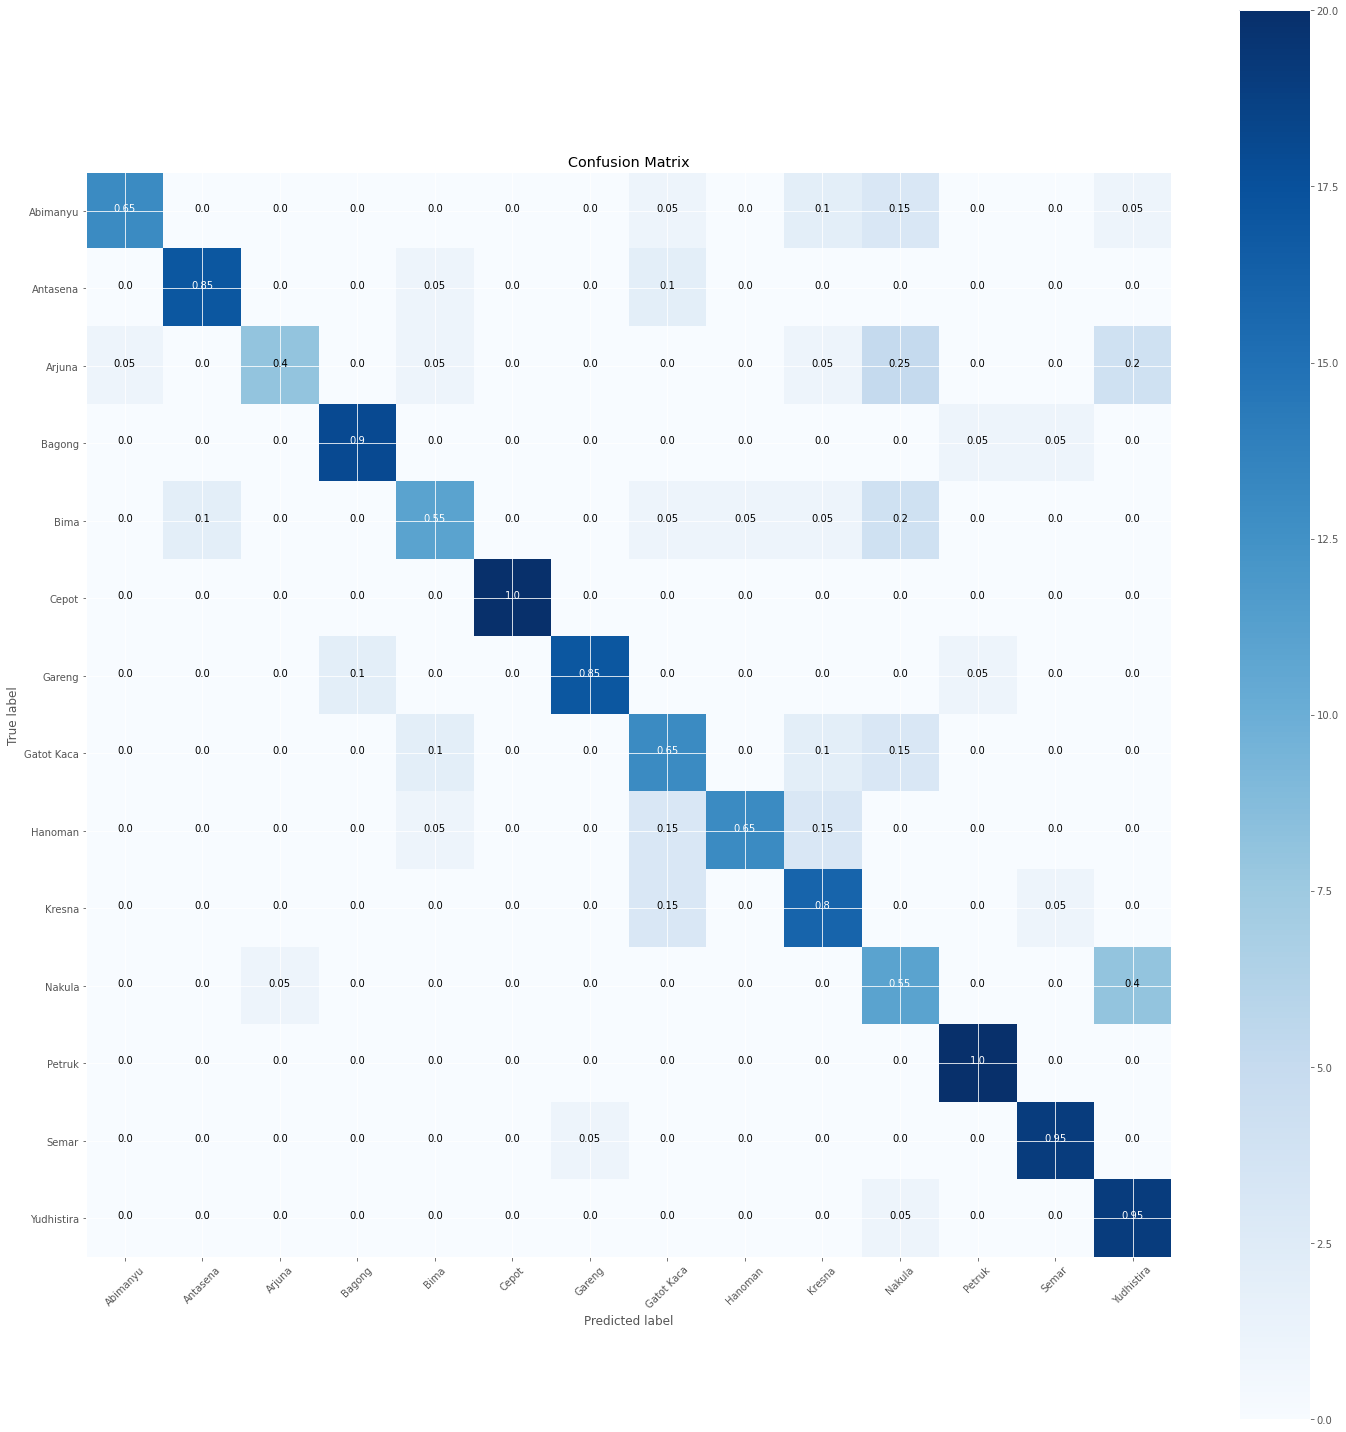

In [33]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in valid_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

# **Loss and Accuracy history**

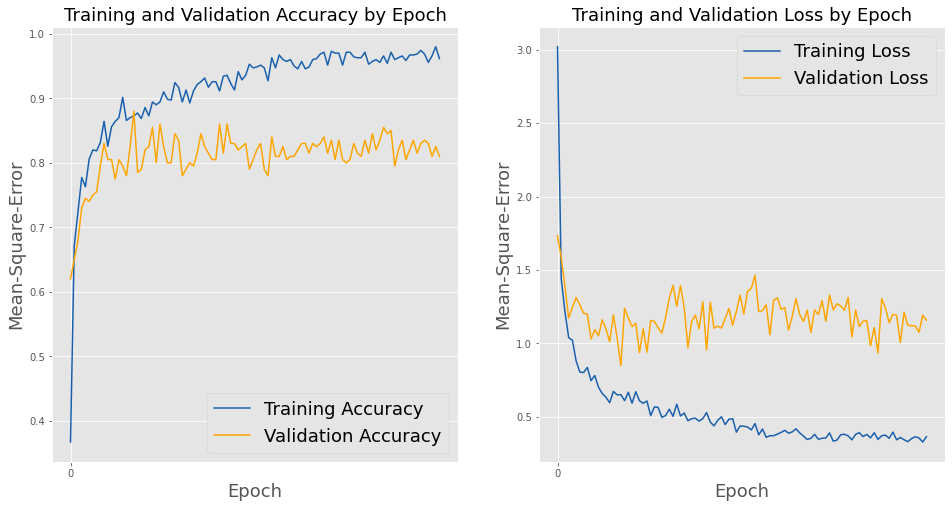

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16, 8))

# Cek hasil akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))

plt.legend(fontsize = 18);

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))


plt.legend(fontsize = 18)

# **Validation Generator**

In [ ]:
model.load_weights("./model_best.h5")

In [ ]:
validation_generator_2 = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size = 256,
    color_mode='rgb'
)

avg_loss = 0
avg_accc = 0

for x_test, y_test in validation_generator_2:
  eval_result = model.evaluate(x_test,y_test)

  if avg_loss == 0:
    avg_loss = eval_result[0]
  else:
    avg_loss = (eval_result[0] + avg_loss) / 2

  if avg_accc == 0:
    avg_accc = eval_result[1]
  else:
    avg_accc = (eval_result[1] + avg_loss) / 2

  if 1 >= len(x_test) / 256:
    break

print("Loss of the model is     -" , avg_loss)
print("Accuracy of the model is -" , avg_accc*100 , "%")

Found 280 images belonging to 14 classes.
8/8 [==============================] - 1s 33ms/step - loss: 1.0337 - accuracy: 0.8477
Loss of the model is     - 1.0336958169937134
Accuracy of the model is - 84.765625 %


# **Save The Model and Convert to .tflite**

In [ ]:
model_save_path = "saved_model/14_types"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models', exist_ok=True)
with open('tflite_models/wayang_types.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/14_types/assets


INFO:tensorflow:Assets written to: saved_model/14_types/assets


# **Validating The Model**

In [ ]:
def img_prep_predict(path):
    img = plt.imread(path)
    img=tf.image.resize(img,(160,160))
    img=tf.expand_dims(img,axis=0)
    img = img/255.
    predmod = np.ravel(model.predict(img))
    a= 0
    nji = 0
    for CATEGORIE in types_dict:
        if predmod[a] > nji:
            mosnt = CATEGORIE
            nji = predmod[a]
        a+=1

    return mosnt

In [ ]:
path = '/content/gatutkaca.jpg'

In [ ]:
img_prep_predict(path)

'Gatot Kaca'

In [ ]:
path = '/content/hanoman.jpg'

In [ ]:
img_prep_predict(path)

'Hanoman'